In [1]:
from os import listdir
from os.path import isfile, join

import loop_tool as lt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
# import time
from IPython import display
from ipywidgets import Output


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import pdb
device = 'cpu'

In [2]:
df = pd.read_pickle("datasets/tensor_dataset.pkl") 
df.head()

,ir,loops_tensor,program_tensor,gflops
0,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(1), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.809471
1,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",42.649964
2,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.809471
3,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.827548
4,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",60.92229


In [3]:
class LoopToolDataset(Dataset):
    def __init__(
        self,
        df,
    ):
        self.df = df

    def __getitem__(self, i):
        return torch.flatten(self.df['program_tensor'].iloc[0].float()).to(device), torch.tensor(self.df['gflops'].iloc[i]).float().to(device)

    def __len__(self):    
        return len(self.df)

In [4]:
loop_tool_dataset = LoopToolDataset(df=df)

In [5]:
test_size = len(loop_tool_dataset.df) // 5
train_size = len(loop_tool_dataset.df) - test_size

print(f'Dataset training validation = {train_size}, {test_size}')
train_set, test_set = torch.utils.data.random_split(loop_tool_dataset, [train_size, test_size])

batch_size = 10
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)

Dataset training validation = 15840, 3960


In [6]:
class SmallNet(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout=0):
        super(SmallNet,self).__init__()
        self.l1 = nn.Linear(in_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,hidden_size)
        self.l7 = nn.Linear(hidden_size,out_size)
        # self.softmax = nn.Softmax(dim=1)
        # self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = self.l7(x)
        return x

In [7]:
model_path = "model_weights.pt"
model = SmallNet(in_size=len(torch.flatten(df['program_tensor'].iloc[0])), out_size=1, hidden_size=516).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

model

SmallNet(
  (l1): Linear(in_features=32, out_features=516, bias=True)
  (l2): Linear(in_features=516, out_features=516, bias=True)
  (l3): Linear(in_features=516, out_features=516, bias=True)
  (l7): Linear(in_features=516, out_features=1, bias=True)
)

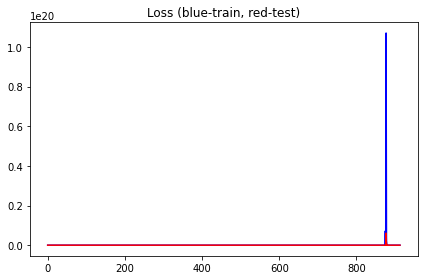

  0%|          | 0/1000 [18:33<?, ?it/s]


In [8]:
train_losses = []
test_losses = []
num_epochs = 1000
test_every = 10

out = Output()
display.display(out)

model.train()

for epoch in tqdm(range(num_epochs)):    
    for state, cost in trainLoad:
        train_losses_batch = []
        
        for state, cost in zip(state, cost):
            # print(state)
            # break
            pred_cost = model(state)[0]
            train_loss = criterion(pred_cost, cost)
            train_losses_batch.append(train_loss.item())

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            

        if epoch % test_every == 0:
            with torch.no_grad():
                model.eval()
                test_losses_batch = []
                for state, cost in testLoad:
                    for state, cost in zip(state, cost):

                        pred_cost = model(state)[0]
                        test_loss = criterion(pred_cost, cost )
                        test_losses_batch.append(test_loss.item())

            train_losses.append(np.mean(train_losses_batch))
            test_losses.append(np.mean(test_losses_batch))
            # torch.save(model.state_dict(), model_path)

            with out:
                display.clear_output(wait=True)
                plt.title('Loss (blue-train, red-test)')
                plt.plot(train_losses, color='blue')
                plt.plot(test_losses, color='red')

                plt.tight_layout()
                plt.show()

    break
    
    


In [9]:
plt.show()

In [11]:
model.eval()

SmallNet(
  (l1): Linear(in_features=32, out_features=516, bias=True)
  (l2): Linear(in_features=516, out_features=516, bias=True)
  (l3): Linear(in_features=516, out_features=516, bias=True)
  (l7): Linear(in_features=516, out_features=1, bias=True)
)

In [12]:
df.head()

,ir,loops_tensor,program_tensor,gflops
0,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(1), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.809471
1,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",42.649964
2,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.809471
3,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",32.827548
4,"v:m_6543\nv:k_6545\nv:n_6544\nn:2::0,1,:::0:::...","[[tensor(1), tensor(0), tensor(1), tensor(0), ...","[tensor(14196.), tensor(0.), tensor(0.), tenso...",60.92229


In [15]:
for i in range(10):
    print(f'predicted = {model(df["program_tensor"].iloc[i].float())[0]}, label = {df["gflops"].iloc[i]}')

predicted = 699406.5, label = 32.809471365638764
predicted = 699406.5, label = 42.64996420901933
predicted = 699406.5, label = 32.809471365638764
predicted = 699406.5, label = 32.82754820936639
predicted = 699406.5, label = 60.922290388548056
predicted = -463665.53125, label = 60.922290388548056
predicted = -463665.53125, label = 32.809471365638764
predicted = -463665.53125, label = 32.82754820936639
predicted = -463665.53125, label = 60.922290388548056
predicted = -463665.53125, label = 32.809471365638764
